In [1]:
from pytube import YouTube
from utils import get_video_ids
from IPython.display import YouTubeVideo

In [2]:
PATH ='/media/dat/dataset/YOUTUBE_BB/youtube_boundingboxes_detection_validation.csv'

# Get all video ids that satisfies the condition as stated 
grouped = get_video_ids(PATH, category='car', min_area=0.1, max_area=0.5, threshold=0.7)
print("Number of videos: %s" % len(grouped))
video_id = list(grouped.groups.keys())[4]

# Download youtube video and save into /tmp/
yt = YouTube('https://www.youtube.com/watch?v=%s' % video_id)
title  = yt.title
stream = yt.streams.filter(file_extension='mp4').first().download('/tmp')

Number of videos: 159


In [3]:
import os
import cv2

# Reference
# https://docs.opencv.org/3.3.0/d4/d15/group__videoio__flags__base.html
VIDEO_FILE = '/tmp/%s.mp4'%title

if not os.path.isfile(VIDEO_FILE):
    raise IOError("No video avaiable.")
cap    = cv2.VideoCapture(VIDEO_FILE)
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv2.CAP_PROP_FPS)
print("Video Stat: Size {}x{} || FPS: {} || Length {} ({:.2f} secs)".format(
        width, height, fps, length, length/fps))

def grab_frame():
    global cap
    if cap.isOpened() and cap.get(1) < length :
        ret,frame = cap.read()
        return cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

Video Stat: Size 492x360 || FPS: 29.97002997002997 || Length 6052 (201.94 secs)


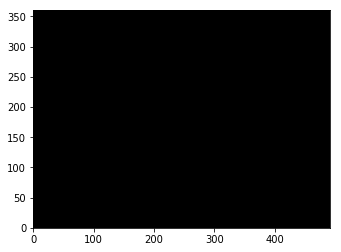

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

%matplotlib inline

fig, ax = plt.subplots()
ax.set_xlim(( 0, width))
ax.set_ylim((0, height))
im = ax.imshow(grab_frame())

def init():
    im.set_data(grab_frame())
    return (im,)

def update(frame):
    im.set_data(grab_frame())
    return (im, )

anim = animation.FuncAnimation(fig, 
                               func    = update, 
                               init_func=init,
                               frames  = length, 
                               interval= 20, 
                               blit    = True)
cap.release()

In [40]:
import torch
import numpy as np
class VideoAnalyzer(object):
    """
    Look for fixed-angle video sequences in a video
    """
    def __init__(self,
                 model        , 
                 data_transform ,
                 metric       = '',
                 stabilizer   = None):

        self.model      = model
        self.data_transform = data_transform
        self.metric     = metric
        self.stabilizer = stabilizer

    def process(self, video_path, sequence_len=50):
        cap    = cv2.VideoCapture(video_path)
        
        # Init video params (video length, width, height, fps)
        if cap.isOpened():
            param = self._set_video_params(cap)
        
        for curr_cursor in range(0 , param['video_length'], sequence_len):
            first_frame, last_frame = self._get_first_last_frames(cap, curr_cursor, sequence_len)
            
            if last_frame is None:
                break
            #    Calculate feature maps of the two frames
            input_a = self.data_transform(first_frame)
            input_b = self.data_transform(last_frame)
            inputs  = torch.stack([input_a, input_b])
            a = self.model(torch.autograd.Variable(inputs))
            print(a)
            
            # Measure distance
        cap.release()

    def _set_video_params(self, cap):
        
        #print("Video Stat: Size {}x{} || FPS: {} || Length {} ({:.2f} secs)".format(
        #         width, height, fps, length, length/fps))
        params = {
            'video_length': int(cap.get(cv2.CAP_PROP_FRAME_COUNT)),
            'video_width' : int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
            'video_height': int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
            'video_fps'   : cap.get(cv2.CAP_PROP_FPS),
        }
        return params
    
    def _get_first_last_frames(self, cap, cursor, sequence_len):
        first_frame_idx =  cursor 
        last_frame_idx  =  cursor + sequence_len
        cap.set(cv2.CAP_PROP_POS_FRAMES,  first_frame_idx)                             
        ret, first_frame = cap.read()
        cap.set(cv2.CAP_PROP_POS_FRAMES,  last_frame_idx)                             
        ret, last_frame = cap.read()
        return first_frame, last_frame

In [41]:
from alexnet import alexnet, preprocessor

alexnet = alexnet(pretrained=True)
video_analyzer = VideoAnalyzer(model=alexnet, data_transform= preprocessor())

AlexNet(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d (64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d (192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d (384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_features=4096)
    (5): ReLU(inplace)
    (6): Linea

In [42]:
VIDEO_FILE = '/tmp/%s.mp4'%title

video_analyzer.process(VIDEO_FILE)

Variable containing:
-0.1265  1.8376 -0.8346  ...  -1.0391  0.8114  1.0678
 0.1537  1.2004 -1.2573  ...  -0.4616  1.1978  1.3631
[torch.FloatTensor of size 2x1000]

Variable containing:
 0.1923  1.8092 -0.5411  ...  -1.2056  1.4737  1.1435
-3.9368 -1.1195 -1.5148  ...  -2.2965 -1.0844 -1.0244
[torch.FloatTensor of size 2x1000]

Variable containing:
-2.8832e+00 -1.5065e+00  4.0479e-01  ...  -2.9016e+00 -1.4022e+00  5.2594e-01
-2.6085e+00  2.2439e-01  4.6906e-01  ...  -2.0618e+00  6.6274e-01 -4.4127e-01
[torch.FloatTensor of size 2x1000]

Variable containing:
-3.7805  0.2033 -1.2390  ...  -3.4950 -0.8778 -2.3156
-3.8775  0.6037 -0.1829  ...  -3.5776 -1.9064  0.8771
[torch.FloatTensor of size 2x1000]

Variable containing:
-3.2214 -0.2944  0.5031  ...  -3.3531 -0.8189 -0.7658
-3.7897 -1.1113  0.6342  ...  -2.7739 -2.1627 -0.6657
[torch.FloatTensor of size 2x1000]

Variable containing:
-3.1504  0.5163  0.8503  ...  -3.4862 -1.5570  0.3921
-6.6436  0.8903 -1.1233  ...  -2.8875 -1.5275  0.987

Variable containing:
-1.3366 -1.8188 -0.0705  ...  -2.3644 -1.7380  0.3315
-1.2932 -1.7993 -0.7715  ...  -1.7599 -1.7860  0.5441
[torch.FloatTensor of size 2x1000]

Variable containing:
 -1.0681  -4.3651   0.7594  ...   -2.6904  -1.4851   0.8191
 -1.6352  -0.7728   0.7128  ...   -0.7751  -2.4979   0.9117
[torch.FloatTensor of size 2x1000]

Variable containing:
  0.6737  -0.2360   5.3399  ...   -0.8349  -2.5863   2.8782
 -4.2091  -2.3887  -0.8286  ...   -5.1460  -5.2316   0.1187
[torch.FloatTensor of size 2x1000]

Variable containing:
-2.4905 -2.2774 -0.5008  ...  -4.8702 -3.3750  0.7545
-3.0184 -0.8914 -1.9734  ...  -3.4799 -1.8800  0.9668
[torch.FloatTensor of size 2x1000]

Variable containing:
 -5.2488  -0.9949  -1.8161  ...   -4.0164  -1.9176   0.4387
 -7.2437  -2.7927   0.3520  ...   -7.5649  -3.3148   0.9846
[torch.FloatTensor of size 2x1000]

Variable containing:
-4.6314e+00 -1.9509e+00  4.2481e-01  ...  -4.6605e+00 -2.3416e+00  5.7506e-01
-5.0853e+00 -2.0085e+00 -2.5240e+00  ...

Variable containing:
 0.2060 -1.8472 -2.4347  ...  -3.3423  1.0514  5.3654
-1.4522 -2.8921  0.3391  ...  -2.4063  1.5612  5.5823
[torch.FloatTensor of size 2x1000]

Variable containing:
-2.1482 -2.4232  1.4799  ...  -3.7325  2.1470  6.0116
 1.8848 -0.0483 -4.1128  ...  -1.4601  1.7625  3.6887
[torch.FloatTensor of size 2x1000]

Variable containing:
 3.7963 -0.0898 -3.4787  ...  -2.0952  1.5174  4.5229
-1.9026 -3.3308 -2.1076  ...   0.1785  0.4623  3.2530
[torch.FloatTensor of size 2x1000]

Variable containing:
 -2.4234  -3.0085  -1.3369  ...   -2.7041   1.7805   2.3897
 -1.5702   1.6982  -2.6962  ...   -3.2678  -0.3003   2.9404
[torch.FloatTensor of size 2x1000]

Variable containing:
 -0.2639   1.1787  -3.1573  ...   -4.9300  -1.3605   1.0830
 -0.1315   1.2618  -2.8722  ...   -5.3702  -0.9115   1.0801
[torch.FloatTensor of size 2x1000]

Variable containing:
 1.1707e+00  6.9071e-01 -5.0406e+00  ...  -5.1716e+00  2.0997e+00  2.2438e+00
-2.4759e+00 -2.3319e+00 -2.3465e+00  ...  -5.3264e+0